In [66]:
import pandas as pd
from models import SimpleContrastiveNetwork, ContrastiveLoss
import ast
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

In [3]:
df = pd.read_csv('data/simclr_data.csv')
df['Positive'] = df['Positive'].apply(ast.literal_eval)
df['Negative'] = df['Negative'].apply(ast.literal_eval)

In [54]:
df['Original CoT'][0]

'In April, Mohammad sold clips to 48 friends.\nIn May, he sold half as many clips as in April.\nTo find out how many clips he sold in May, we need to divide the number of clips sold in April by 2.\n48 / 2 = 24\nSo, Mohammad sold 24 clips in May.\nTo find out how many clips he sold altogether in April and May, we need to add the number of clips sold in April and May.\n48 + 24 = 72\nTherefore, Mohammad sold a total of 72 clips in April and May.'

,Problem Number,Prompt,Original CoT,Changed Solution,Reasoning Trace,Positive,Negative
0,1,Mohammad sold clips to 48 of his friends in Ap...,"In April, Mohammad sold clips to 48 friends.\n...","First, let's calculate how many clips Mohammad...","First, let's calculate how many clips Mohammad...","[First, let's calculate how many clips John so...","[Lastly, let's add the cost of the unicorn piñ..."
1,1,Mohammad sold clips to 48 of his friends in Ap...,"In April, Mohammad sold clips to 48 friends.\n...","First, let's calculate how many clips Mohammad...","Now, let's find out how many clips he sold alt...","[Now, let's find out how many clips he sold al...","[Therefore, it will take Mohammad 5 hours to r..."
2,1,Mohammad sold clips to 48 of his friends in Ap...,"In April, Mohammad sold clips to 48 friends.\n...","First, let's calculate how many clips Mohammad...","Therefore, Mohammad sold a total of 72 clips i...","[Therefore, John sold a total of 72 clips in A...","[Therefore, Mohammad practices for a total of ..."
3,2,Mohammad earns $12 an hour for babysitting. Ye...,"To find out how much Mohammad earned, we need ...","To find out how much Mohammad earned, we need ...","To find out how much Mohammad earned, we need ...","[To find out how much John earned, we need to ...","[Now, let's add up all the money Mohammad has ..."
4,2,Mohammad earns $12 an hour for babysitting. Ye...,"To find out how much Mohammad earned, we need ...","To find out how much Mohammad earned, we need ...","Now, let's multiply his earnings per minute by...","[Now, let's multiply his earnings per minute b...","[Therefore, the unicorn piñata and the treats ..."
...,...,...,...,...,...,...,...
121,46,It's Mohammad's birthday party. His parents bo...,Sure! Let's break it down step by step.\n\nFir...,Sure! Let's calculate the cost of the treats f...,"Therefore, the unicorn piñata and the treats c...","[Therefore, the unicorn piñata and the treats ...","[Next, let's calculate the number of DVDs sold..."
122,47,Mohammad practices the piano for 20 minutes a ...,"First, let's calculate how long Mohammad pract...",Step 1: Find out how long Mohammad practices t...,"First, let's calculate how long Mohammad pract...","[First, let's calculate how long John practice...","[Now, let's calculate Mohammad's total pay for..."
123,47,Mohammad practices the piano for 20 minutes a ...,"First, let's calculate how long Mohammad pract...",Step 1: Find out how long Mohammad practices t...,"Next, let's calculate how long Mohammad practi...","[Next, let's calculate how long John practices...","[Therefore, Mohammad was left with 160 valuabl..."
124,47,Mohammad practices the piano for 20 minutes a ...,"First, let's calculate how long Mohammad pract...",Step 1: Find out how long Mohammad practices t...,"Finally, let's calculate how long Mohammad pra...","[Finally, let's calculate how long John practi...",[Step 9: Answer the question. Mohammad shovele...


In [63]:
for i in range(3):
    print(f"REASONING STEP {i + 1}: ", df['Reasoning Trace'][i])

REASONING STEP 1:  First, let's calculate how many clips Mohammad sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2.  48 / 2 = 24  So, Mohammad sold 24 clips in May.
REASONING STEP 2:  Now, let's find out how many clips he sold altogether in April and May. To do this, we need to add the number of clips sold in April and the number of clips sold in May.  48 + 24 = 72
REASONING STEP 3:  Therefore, Mohammad sold a total of 72 clips in April and May.


In [64]:
for i, row in df[:1].iterrows():
    print("POSITIVE EXAMPLES:")
    for i in range(len(row['Positive'])):
        print(i+1, row['Positive'][i])
    print("NEGATIVE EXAMPLES")
    for i in range(len(row['Negative'])):
        print(i+1, row['Negative'][i])
    print()
    print()

POSITIVE EXAMPLES:
1 First, let's calculate how many clips John sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2.  48 / 2 = 24  So, John sold 24 clips in May.
2 First, let's calculate how many clips Susan sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2.  48 / 2 = 24  So, Susan sold 24 clips in May.
3 First, let's calculate how many clips Betty sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2.  48 / 2 = 24  So, Betty sold 24 clips in May.
4 First, let's calculate how many clips Adam sold in May. We know that he sold half as many clips in May as he did in April. To find this out, we need to divide the number of clips sold in April by 2.  48 / 2 = 24  So, Adam sold 24 clips i

In [26]:
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
embedding = sent_transformer.encode("Attention is all you need.")
print(type(embedding), embedding.shape)

<class 'numpy.ndarray'> (384,)


In [27]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print("MPS device not found, falling back to CPU.")
    device = torch.device("cpu")

tensor([1.], device='mps:0')


In [28]:
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

def encode_sentences(sent_transformer, sentences):
    return sent_transformer.encode(sentences, batch_size=32)

# Prepare dataset
def prepare_data(df):
    pos_embeddings = []
    neg_embeddings = []
    for _, row in df.iterrows():
        pos_sentences = row['Positive']
        neg_sentences = row['Negative']
        # Encode sentences
        pos_embeddings.append(encode_sentences(sent_transformer, pos_sentences))
        neg_embeddings.append(encode_sentences(sent_transformer, neg_sentences))
    return np.array(pos_embeddings), np.array(neg_embeddings)

In [29]:
pos_embeddings, neg_embeddings = prepare_data(df)

In [34]:
model = SimpleContrastiveNetwork().to(device)
contrastive_loss = ContrastiveLoss().to(device)

In [38]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Convert embeddings to Tensor and create a DataLoader
pos_tensor = torch.tensor(pos_embeddings, dtype=torch.float).to(device)
neg_tensor = torch.tensor(neg_embeddings, dtype=torch.float).to(device)

# Assuming all positive examples are to be paired with all negative examples
# This may need adjustment based on your exact training setup
dataset = TensorDataset(pos_tensor, neg_tensor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for pos_batch, neg_batch in loader:
        optimizer.zero_grad()
        
        # Forward pass
        pos_embeddings = model(pos_batch.squeeze(0))  # Adjust dimensions as necessary
        neg_embeddings = model(neg_batch.squeeze(0))  # Adjust dimensions as necessary
        
        # Compute loss for each positive against all negatives
        # You might need to adapt this part depending on how your contrastive loss is implemented
        loss = contrastive_loss(pos_embeddings, neg_embeddings)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader)}")


/var/folders/8y/j9pbnmqj2t1bn5kv9ps9lg680000gn/T/ipykernel_12041/3223644806.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tensor = torch.tensor(pos_embeddings, dtype=torch.float).to(device)
/var/folders/8y/j9pbnmqj2t1bn5kv9ps9lg680000gn/T/ipykernel_12041/3223644806.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_tensor = torch.tensor(neg_embeddings, dtype=torch.float).to(device)


Epoch 1, Loss: 1.7438806295394897
Epoch 2, Loss: 1.7395426034927368
Epoch 3, Loss: 1.7348209619522095
Epoch 4, Loss: 1.729673981666565
Epoch 5, Loss: 1.7240546941757202
Epoch 6, Loss: 1.7179092168807983
Epoch 7, Loss: 1.7111778259277344
Epoch 8, Loss: 1.7037900686264038
Epoch 9, Loss: 1.6956685781478882
Epoch 10, Loss: 1.6867221593856812
Epoch 11, Loss: 1.6768490076065063
Epoch 12, Loss: 1.6659313440322876
Epoch 13, Loss: 1.65383780002594
Epoch 14, Loss: 1.6404170989990234
Epoch 15, Loss: 1.625497817993164
Epoch 16, Loss: 1.6088862419128418
Epoch 17, Loss: 1.5903669595718384
Epoch 18, Loss: 1.5696955919265747
Epoch 19, Loss: 1.5466052293777466
Epoch 20, Loss: 1.5208044052124023
Epoch 21, Loss: 1.4919811487197876
Epoch 22, Loss: 1.4598137140274048
Epoch 23, Loss: 1.423977255821228
Epoch 24, Loss: 1.384168028831482
Epoch 25, Loss: 1.340123176574707
Epoch 26, Loss: 1.291657567024231
Epoch 27, Loss: 1.2386976480484009
Epoch 28, Loss: 1.1813180446624756
Epoch 29, Loss: 1.1197552680969238
Ep

Attempt 2

In [67]:
class ReasoningDataset(Dataset):
    def __init__(self, dataframe, sent_transformer):
        self.dataframe = dataframe
        self.sent_transformer = sent_transformer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Encode the reasoning trace as the "anchor"
        anchor_embedding = self.encode_sentences([row['Reasoning Trace']])
        # Encode positive and negative examples
        positive_embeddings = self.encode_sentences(row['Positive'])
        negative_embeddings = self.encode_sentences(row['Negative'])
        return anchor_embedding, positive_embeddings, negative_embeddings

    def encode_sentences(self, sentences):
        return self.sent_transformer.encode(sentences, batch_size=32, show_progress_bar=False)

sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')

dataset = ReasoningDataset(df, sent_transformer)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [68]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    print("MPS device not found, falling back to CPU.")
    device = torch.device("cpu")

model = SimpleContrastiveNetwork().to(device)
contrastive_loss = ContrastiveLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for anchor, positives, negatives in loader:
            optimizer.zero_grad()
            
            anchor = anchor.to(device).squeeze(0)  # Remove batch dimension
            positives = positives.to(device).squeeze(0)
            negatives = negatives.to(device).squeeze(0)

            anchor_embedding = model(anchor)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)

            combined_embeddings = torch.cat((positive_embeddings, negative_embeddings), dim=0)
            # labels = torch.zeros(positive_embeddings.size(0), dtype=torch.long).to(device)  # Positives are the correct ones
            loss = contrastive_loss(anchor_embedding.repeat(combined_embeddings.size(0), 1), combined_embeddings)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader)}")

train(model, loader, optimizer, epochs=10)


Epoch 1, Loss: 2.8895890353217957
Epoch 2, Loss: 2.565844974820576
Epoch 3, Loss: 2.5241230669475736
Epoch 4, Loss: 2.5089127165930614
Epoch 5, Loss: 2.5014477589773754
Epoch 6, Loss: 2.4971468827081105
Epoch 7, Loss: 2.4944196825935725
Epoch 8, Loss: 2.4925365807518127
Epoch 9, Loss: 2.4911829195325335
Epoch 10, Loss: 2.490171300040351


In [69]:
new_sentences = ["Your new sentence here."]
original_embeddings = sent_transformer.encode(new_sentences)

original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

with torch.no_grad():
    model.eval()
    transformed_embeddings = model(original_embeddings_tensor)

In [73]:
# transformed_embeddings = transformed_embeddings.cpu().numpy()

cos_sim = cosine_similarity(
    original_embeddings,
    transformed_embeddings 
)
cos_sim

array([[0.01378504, 0.02890066],
       [0.0325819 , 0.05401296]], dtype=float32)

In [88]:
rand_df = df.sample(1)

In [94]:
print(rand_df['Positive'].tolist())

[['Step 2: Calculate the number of tennis balls John hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.', 'Step 2: Calculate the number of tennis balls Susan hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.', 'Step 2: Calculate the number of tennis balls Betty hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.', 'Step 2: Calculate the number of tennis balls Adam hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.', 'Step 2: Calculate the number of tennis balls Bob hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.', 'Step 2: Calculate the number of tennis balls Alice hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.']]


In [87]:
df.sample(10)['Reasoning Trace'].tolist()

['Step 4: Mohammad added enough gummy worms to double the weight once again. This means the weight became 8 * 2 = 16 pounds.',
 "First, let's calculate the total number of slices in the large pizzas. Since each large pizza has 16 slices, the total number of slices in the large pizzas is 2 * 16 = 32 slices.",
 "Now, let's calculate the profit made in a week. The profit made in a week is the selling price per DVD minus the cost per DVD, multiplied by the number of DVDs sold in a week. So, the profit made in a week is ($15 - $6) * 2500 = $22500.",
 "Now, let's calculate the sales for this month. We know that Mohammad sold twice as much this month, so he sold 2 * 8 = <<2*8=16>>16 large paintings.  The sales from large paintings this month would be 16 * $60 = $<<16*60=960>>960.  He also sold twice as many small paintings, so he sold 2 * 4 = <<2*4=8>>8 small paintings.  The sales from small paintings this month would be 8 * $30 = $<<8*30=240>>240.",
 'Therefore, the unicorn piñata and the tr

In [98]:
new_sentences = rand_df['Positive'].tolist()[0][:3] + rand_df['Negative'].tolist()[0][:3]
new_sentences

['Step 2: Calculate the number of tennis balls John hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.',
 'Step 2: Calculate the number of tennis balls Susan hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.',
 'Step 2: Calculate the number of tennis balls Betty hit out of the next 75. He hit 1/3 of the next 75 balls, so he hit (1/3) * 75 = 25 balls.',
 "Finally, let's calculate how many pages Mohammad writes in a year. There are 52 weeks in a year, so he writes a total of 12 x 52 = <<12*52=624>>624 pages in a year.",
 'First, we need to calculate the amount of money Mohammad spends on each category.  Food: 30% of $1000 = $300 Accommodation: 15% of $1000 = $150 Entertainment: 25% of $1000 = $250',
 "Finally, let's calculate the total cost of the ingredients. The cheddar cheese costs $10, the cream cheese costs $5, and the cold cuts cost $20, so the total cost is $10 + $5 + $20 = $<<10+5+20=35>>35."]

In [99]:
# new_sentences = []
new_sentences = rand_df['Positive'].tolist()[0][:3] + rand_df['Negative'].tolist()[0][:3]

sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

model.eval()

with torch.no_grad():
    transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

original_cos_sim_matrix = cosine_similarity(original_embeddings)

print("Original Embedding Cosine Similarity Matrix:\n", original_cos_sim_matrix)

transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)

print("Transformed Embedding Cosine Similarity Matrix:\n", transformed_cos_sim_matrix)

Original Embedding Cosine Similarity Matrix:
 [[1.0000004  0.91875684 0.92670006 0.22455674 0.18415436 0.10107906]
 [0.91875684 1.0000002  0.92716515 0.20406833 0.1961731  0.15837513]
 [0.92670006 0.92716515 1.0000001  0.24074642 0.20589042 0.12167417]
 [0.22455674 0.20406833 0.24074642 1.0000001  0.34604192 0.10385157]
 [0.18415436 0.1961731  0.20589042 0.34604192 1.0000001  0.32001382]
 [0.10107906 0.15837513 0.12167417 0.10385157 0.32001382 1.        ]]
Transformed Embedding Cosine Similarity Matrix:
 [[1.         0.99095905 0.99229336 0.96267056 0.9637885  0.96387327]
 [0.99095905 1.0000002  0.99296373 0.9620806  0.96717143 0.9650275 ]
 [0.99229336 0.99296373 1.0000001  0.9604248  0.96636784 0.9630014 ]
 [0.96267056 0.9620806  0.9604248  1.         0.97158986 0.97914225]
 [0.9637885  0.96717143 0.96636784 0.97158986 1.         0.9770546 ]
 [0.96387327 0.9650275  0.9630014  0.97914225 0.9770546  1.        ]]


In [78]:
new_sentences = [
    "To find out how many apples were sold in total, we add the 15 apples sold on Monday to the 20 apples sold on Tuesday.",
    "Determining the total number of oranges involves subtracting the 5 oranges that spoiled from the 25 oranges we had in stock.",
    "To calculate the final score, we add the 20 points from round one to the 30 points from round two.",
    "We figure out the total distance traveled by adding the 100 kilometers driven on Friday to the 150 kilometers on Saturday.",
    "To prevent oranges from spoiling, it is important to not keep too many in stock."
]

sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
original_embeddings = sent_transformer.encode(new_sentences, batch_size=32)
original_embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float).to(device)

model.eval()

with torch.no_grad():
    transformed_embeddings = model(original_embeddings_tensor).cpu().numpy()

original_cos_sim_matrix = cosine_similarity(original_embeddings)

print("Original Embedding Cosine Similarity Matrix:\n", original_cos_sim_matrix)

transformed_cos_sim_matrix = cosine_similarity(transformed_embeddings)

print("Transformed Embedding Cosine Similarity Matrix:\n", transformed_cos_sim_matrix)

Original Embedding Cosine Similarity Matrix:
 [[ 1.0000002   0.53986835  0.27538922  0.23886892  0.27677894]
 [ 0.53986835  0.9999999   0.30155277  0.23248272  0.61654377]
 [ 0.27538922  0.30155277  1.0000002   0.21186781 -0.02868765]
 [ 0.23886892  0.23248272  0.21186781  1.0000001  -0.01552333]
 [ 0.27677894  0.61654377 -0.02868765 -0.01552333  1.0000001 ]]
Transformed Embedding Cosine Similarity Matrix:
 [[1.0000001  0.9531541  0.9180465  0.92852825 0.87054193]
 [0.9531541  0.9999999  0.9170275  0.9260527  0.91981244]
 [0.9180465  0.9170275  1.         0.90998316 0.8097435 ]
 [0.92852825 0.9260527  0.90998316 0.99999976 0.84056157]
 [0.87054193 0.91981244 0.8097435  0.84056157 0.99999976]]


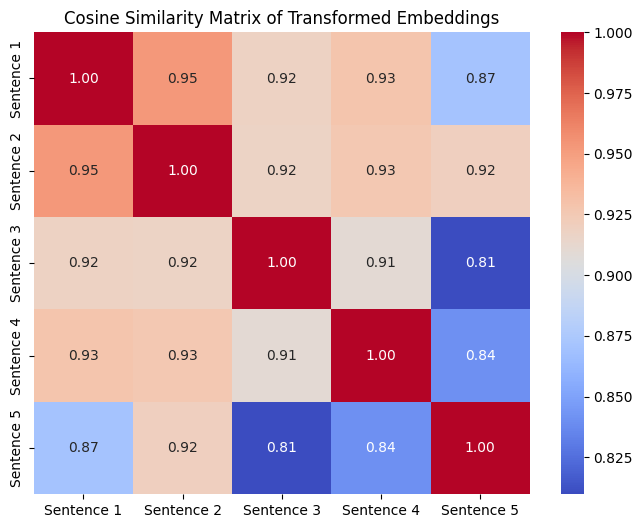

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn to create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(transformed_cos_sim_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))],
            yticklabels=[f"Sentence {i+1}" for i in range(len(new_sentences))])
plt.title('Cosine Similarity Matrix of Transformed Embeddings')
plt.show()